In [72]:
# given some description of the encoding rule, expand a logical circuit into an encoded circuit
# this entails interleaving the logical circuit with syndrome measurement and error correction
# each logical operator should be expanded into the encoded manifold as well
# NOTE: we could think about how to generalize this to codes, but for now its okay to keep specific to ours
from quantum_logical.qudit_op import QutritUnitary
from qiskit.circuit.random import random_circuit
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
import qutip as qt

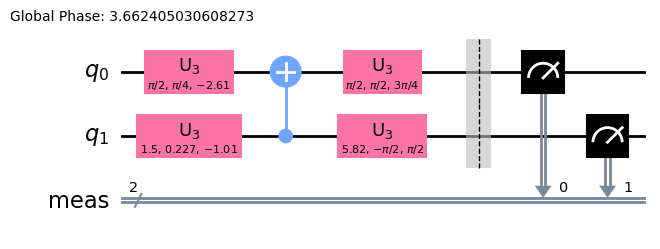

In [73]:
input_circuit = random_circuit(2, 4, seed=42, max_operands=2)
input_circuit = transpile(input_circuit, basis_gates=["u3", "cx"], optimization_level=3)
input_circuit.measure_all()
input_circuit.draw(output="mpl")

To create logical operators use the following transformation:
\begin{align*}
A = |L_0\rangle\langle0| + |L_1\rangle\langle1|\\
U' = A U A^\dagger
\end{align*}
where U is the logical unitary that acts on the $|0\rangle$ and $|1\rangle$ states.


In [74]:
from quantum_logical.basis import SNAILConcatWithAncilla

encoding = SNAILConcatWithAncilla()
A = encoding.logical_basis.transform_operator
A

Quantum object: dims = [[3, 3, 3], [2]], shape = (27, 2), type = oper, isherm = False
Qobj data =
[[ 0.35355339  0.35355339]
 [ 0.          0.        ]
 [ 0.35355339 -0.35355339]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.35355339 -0.35355339]
 [ 0.          0.        ]
 [ 0.35355339  0.35355339]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.35355339 -0.35355339]
 [ 0.          0.        ]
 [ 0.35355339  0.35355339]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.35355339  0.35355339]
 [ 0.          0.        ]
 [ 0.35355339 -0.35355339]]

In [75]:
from quantum_logical.operators import transform_ge_to_gf_gate
from qiskit.circuit.library import HGate, CZGate, CXGate, ZGate

cz_gf = transform_ge_to_gf_gate(CZGate().to_matrix())
cz_gf = QutritUnitary(cz_gf, "cz_gf")
cx_gf = transform_ge_to_gf_gate(CXGate().to_matrix())
cx_gf = QutritUnitary(cx_gf, "cx_gf")
z_gf = transform_ge_to_gf_gate(ZGate().to_matrix())
z_gf = QutritUnitary(z_gf, "z_gf")
h_gf = transform_ge_to_gf_gate(HGate().to_matrix())
h_gf = QutritUnitary(h_gf, "h_gf")

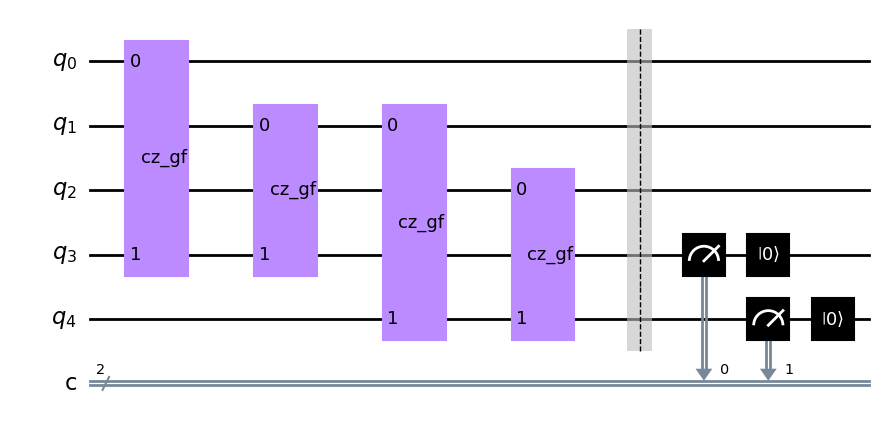

In [76]:
phase_syndrome_subcircuit = QuantumCircuit(5, 2)
phase_syndrome_subcircuit.append(cz_gf, [0, 3])
phase_syndrome_subcircuit.append(cz_gf, [1, 3])
phase_syndrome_subcircuit.append(cz_gf, [1, 4])
phase_syndrome_subcircuit.append(cz_gf, [2, 4])
phase_syndrome_subcircuit.barrier()
phase_syndrome_subcircuit.measure([3, 4], [0, 1])
phase_syndrome_subcircuit.reset([3, 4])

# classically conditioned on the syndrome, we can apply the appropriate correction

phase_syndrome_subcircuit.draw("mpl")

In [77]:
# # NOTE: in the expansion pass, we should probably be able to define known rules ahead of time
# # e.g. known translation between logical CNOT and encoded CNOT rather than relying on the
# # mathematical expression which will lead to a harder decomposition problem in the next stage
# from qiskit.transpiler.basepasses import TransformationPass

# class EncodedCircuitExpansionPass(TransformationPass):
#     def __init__(self, encoding):
#         super().__init__()
#         self.encoding = encoding

#     def run(self, dag):

In [78]:
# TODO: references
# https://qiskit.org/documentation/stable/0.28/tutorials/noise/6_repetition_code.html
# https://github.com/qiskit-community/qiskit-qec/blob/main/src/qiskit_qec/circuits/repetition_code.py

In [79]:
# Setup a base quantum circuit for our experiments
encoding = QuantumRegister(3)
stabilizer = QuantumRegister(2)
encoding_q0, encoding_q1, encoding_q2 = encoding
stabilizer_q0, stabilizer_q1 = stabilizer
# Results of the encoding
results = ClassicalRegister(3)

result_b0, result_b1, result_b2 = results

# For measuring the stabilizer
syndrome = ClassicalRegister(2)

syndrome_b0, syndrome_b1 = syndrome

# The actual qubit which is encoded
state = encoding[0]

# The ancillas used for encoding the state
ancillas = encoding[1:]


# Initializing
def initialize_circuit() -> QuantumCircuit:
    return QuantumCircuit(encoding, stabilizer, results, syndrome)

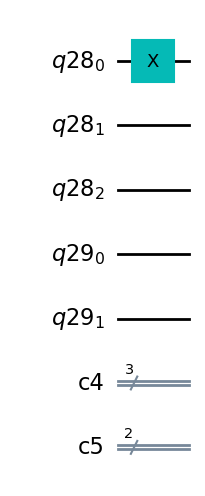

In [80]:
initial_state = initialize_circuit()

initial_state.x(encoding[0])

initial_state.draw(output="mpl")

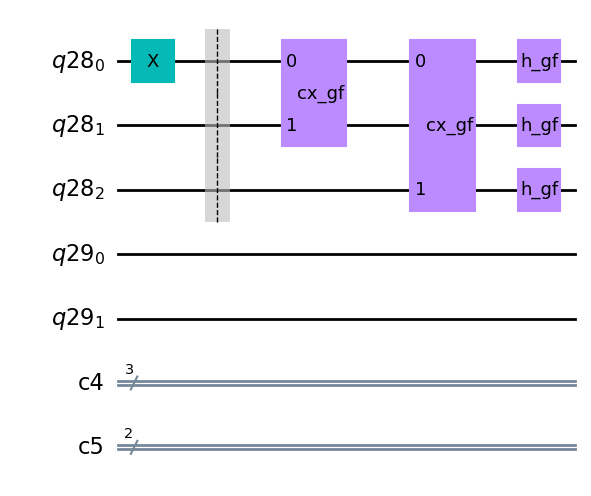

In [81]:
# Encoding using bit flip code
def encode_gf_phase_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        # qc.cx(state, ancilla)
        qc.append(cx_gf, [state, ancilla])
    # qc.h(encoding)
    qc.append(h_gf, [encoding])
    return qc


# The circuit encoding our qubit
encoding_circuit = encode_gf_phase_flip(initialize_circuit(), state, ancillas)

# The circuit including all parts so far
complete_circuit = initial_state.compose(encoding_circuit)
complete_circuit.draw(output="mpl")

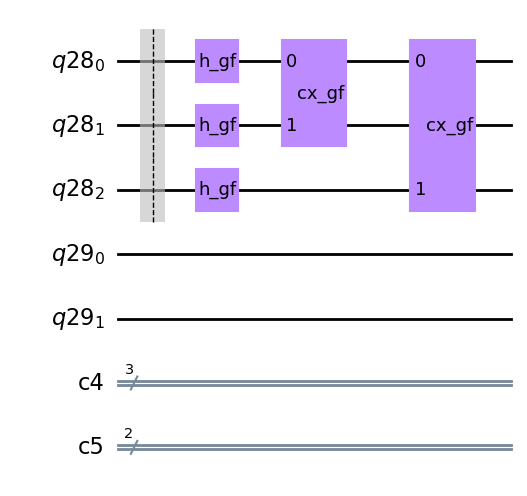

In [82]:
# Decoding (doing the reverse)
def decode_bit_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    qc.append(h_gf, [encoding])
    for ancilla in ancillas:
        # qc.cx(state, ancilla)
        qc.append(cx_gf, [state, ancilla])
    return qc


decoding_circuit = decode_bit_flip(initialize_circuit(), state, ancillas)

decoding_circuit.draw(output="mpl")

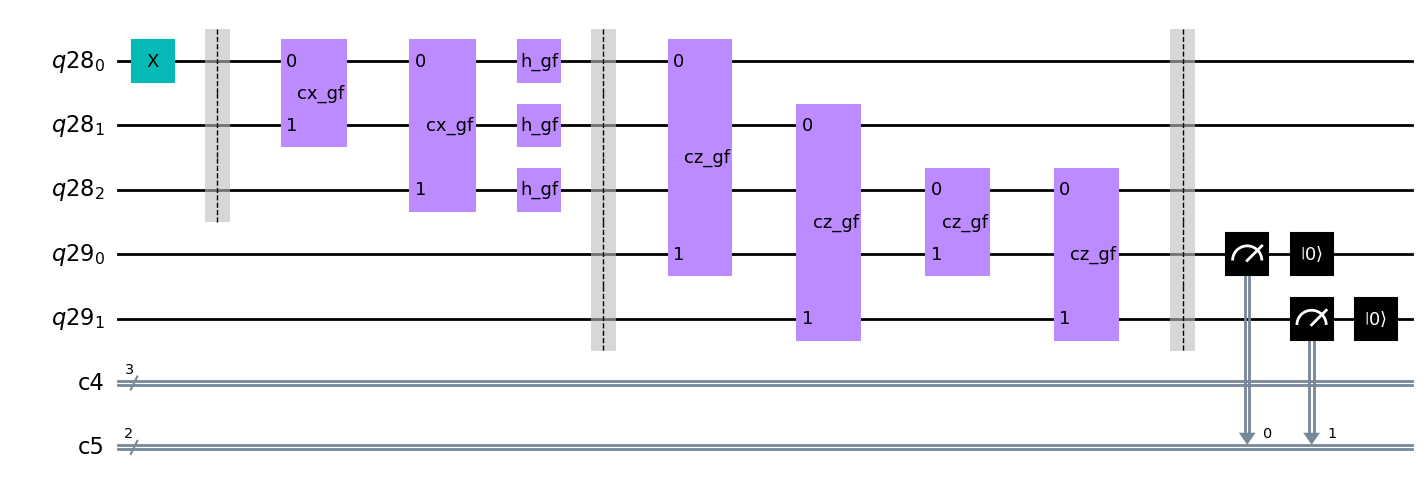

In [83]:
# Add functions such that the classical bits can be used to see which qubit is flipped in the case a single qubit is flipped.
# Use 2 classical bits for it.
# 0 = 00 = no qubit flipped
# 1 = 01 = first qubit (qubit 0) flipped
# 2 = 10 second qubit (qubit 1) flipped
# 3 = 11 = third qubit (qubit 2) flipped
def measure_syndrome_bit(qc, encoding, stabilizer):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding
    stabilizer_q0, stabilizer_q1 = stabilizer

    # qc.cx(encoding_q0, stabilizer_q0)
    # qc.cx(encoding_q2, stabilizer_q0)
    # qc.cx(encoding_q1, stabilizer_q1)
    # qc.cx(encoding_q2, stabilizer_q1)
    qc.append(cz_gf, [encoding_q0, stabilizer_q0])
    qc.append(cz_gf, [encoding_q2, stabilizer_q0])
    qc.append(cz_gf, [encoding_q1, stabilizer_q1])
    qc.append(cz_gf, [encoding_q2, stabilizer_q1])

    ####### measure and reset the ancillae
    qc.barrier()
    qc.measure(stabilizer, syndrome)
    qc.reset(stabilizer)
    # with qc.if_test((syndrome_b0, 1)):
    #     qc.x(stabilizer_q0)
    # with qc.if_test((syndrome_b1, 1)):
    #     qc.x(stabilizer_q1)

    return qc


syndrome_circuit = measure_syndrome_bit(initialize_circuit(), encoding, stabilizer)

complete_circuit = initial_state.compose(encoding_circuit).compose(syndrome_circuit)
complete_circuit.draw("mpl")

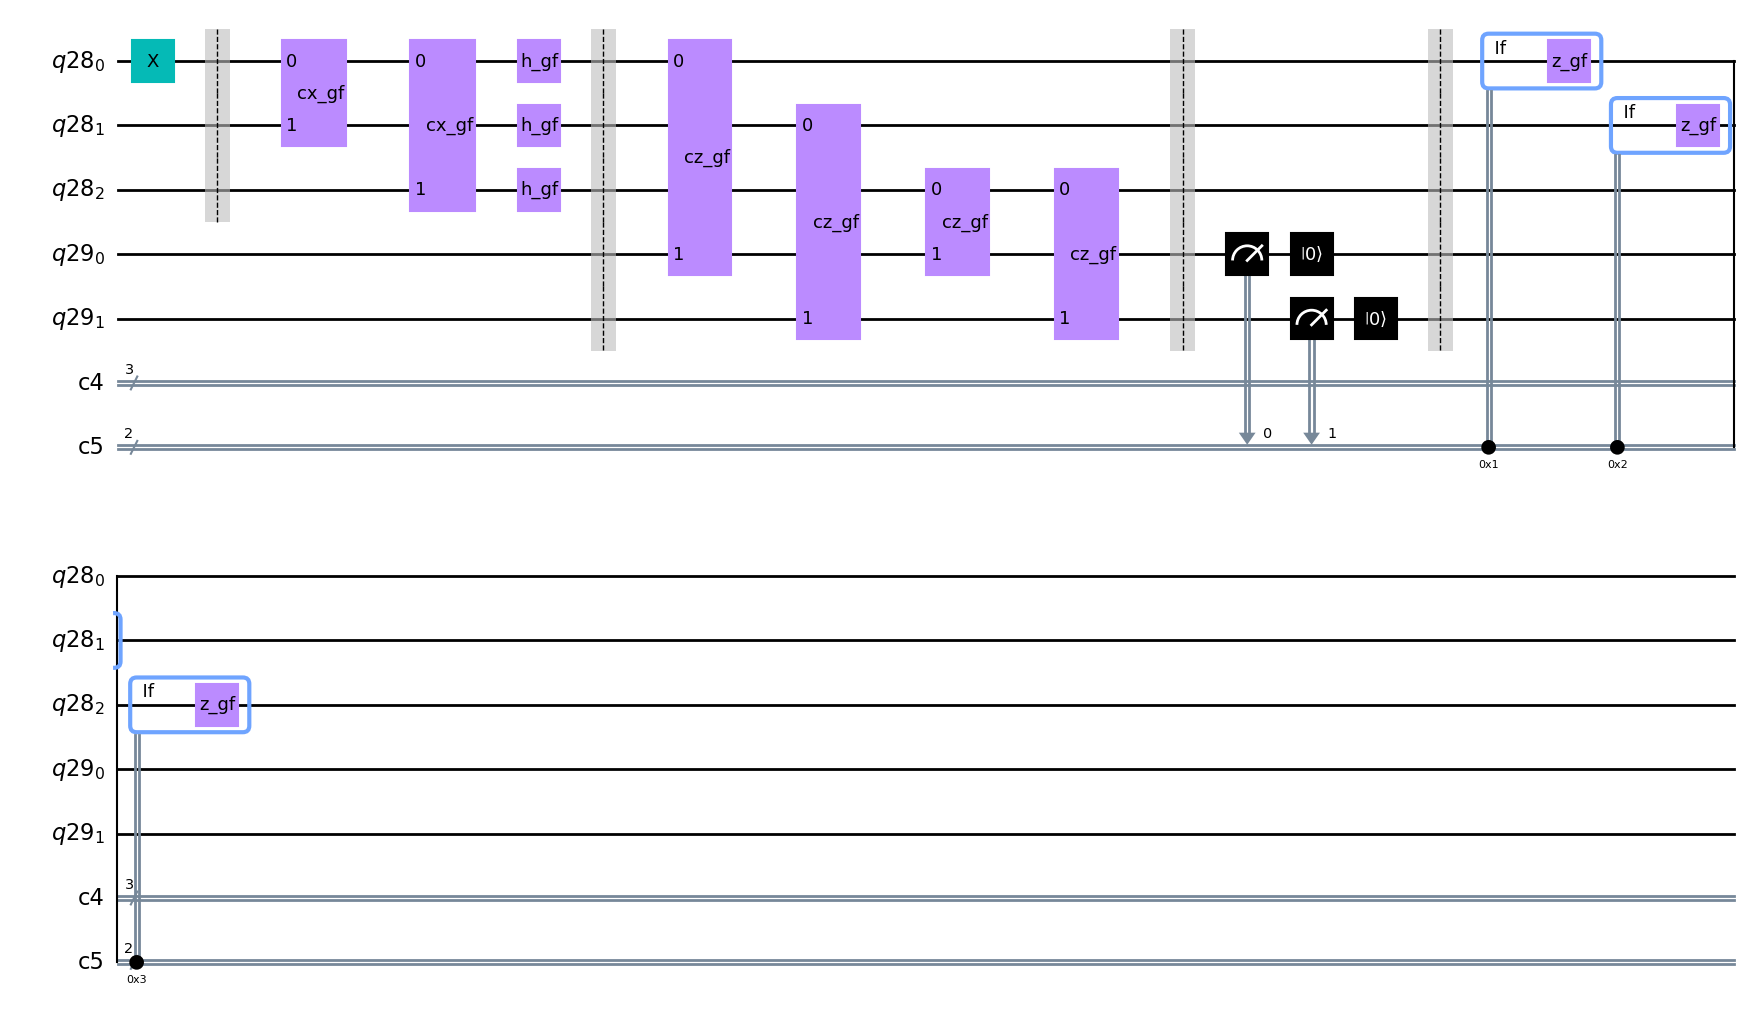

In [84]:
# Correct the errors, remember how we encoded the errors above!
def apply_correction_bit(qc, encoding, syndrome):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding

    for i in range(0, encoding.size):
        with qc.if_test((syndrome, i + 1)):
            # qc.z(encoding[i])
            qc.append(z_gf, [encoding[i]])

    return qc


correction_circuit = apply_correction_bit(initialize_circuit(), encoding, syndrome)
complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
)
complete_circuit.draw(output="mpl")

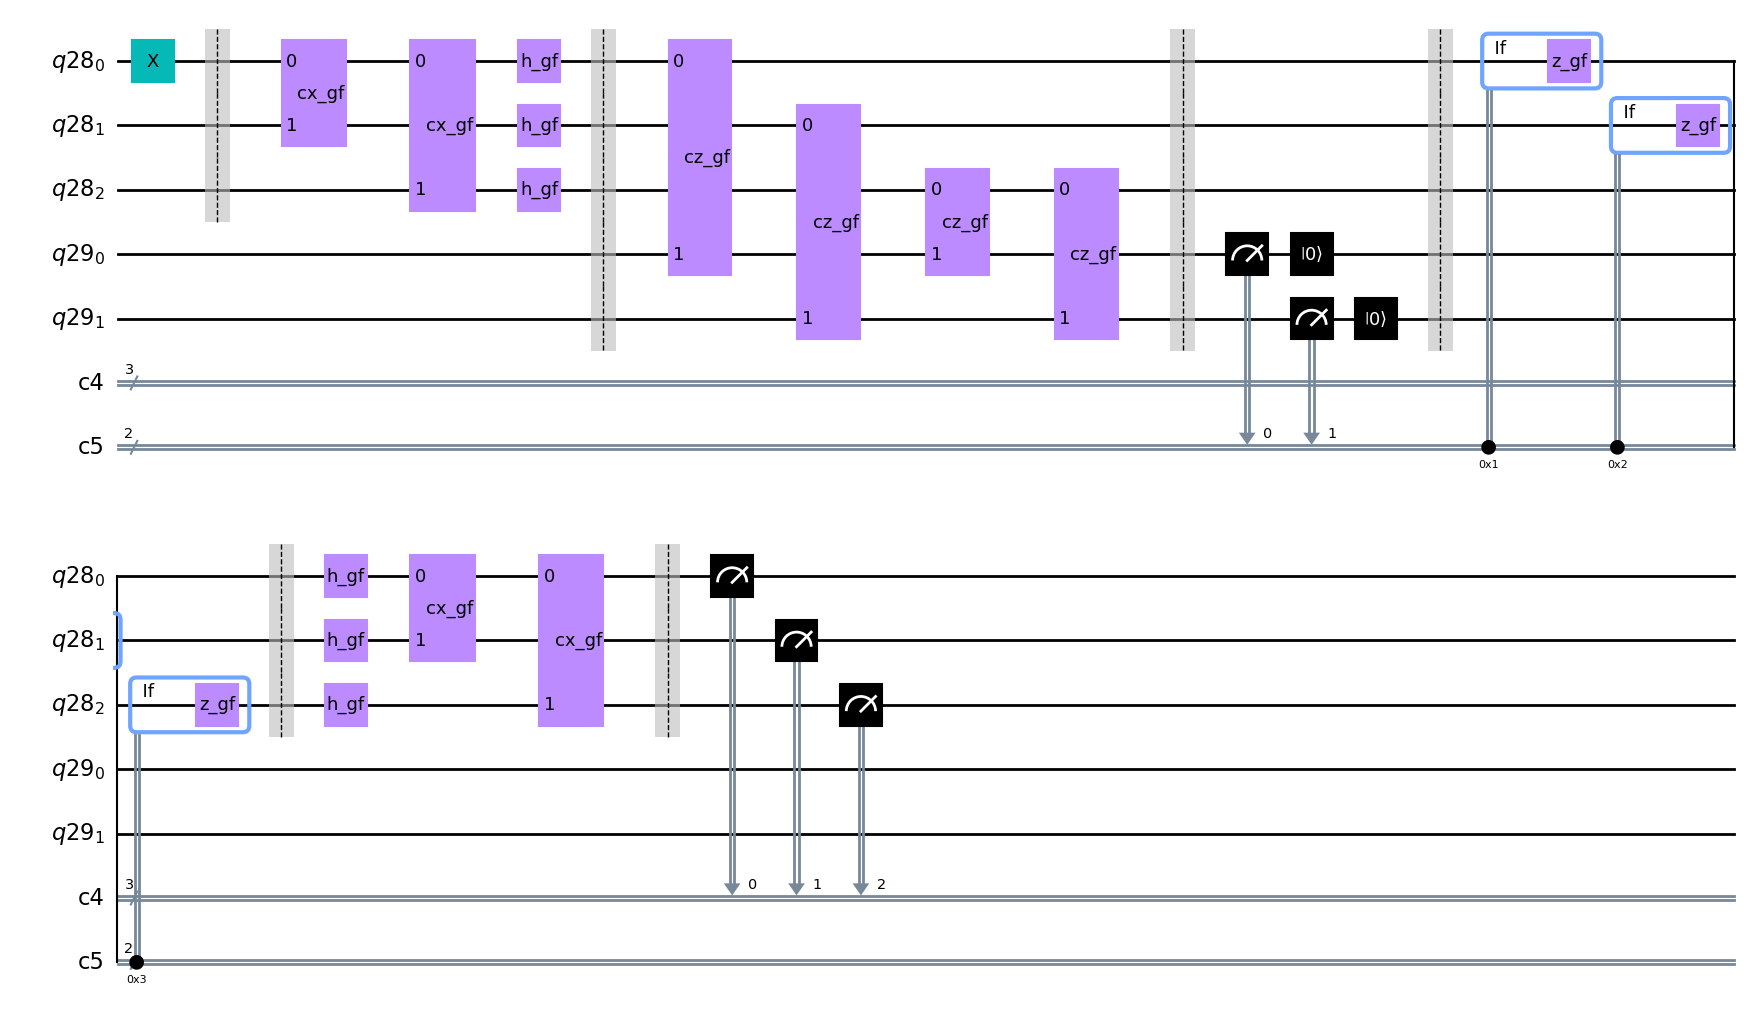

In [85]:
def apply_final_readout(qc, encoding, results):
    qc.barrier(encoding)
    qc.measure(encoding, results)
    return qc


measuring_circuit = apply_final_readout(initialize_circuit(), encoding, results)
complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)
complete_circuit.draw(output="mpl")